**Multi-Class Classification and Bounding Box Generation for images containing Airborne Objects**

*What's been given :*
- A dataset stored at the root of this repository containing :
    - Videos from which images need to be extracted to constitute the training image data.
    - CSV files containing the timestamps as well as the bounding boxes for the objects detected. 
    - Testing images that will be used for the evaluation of the model.
- Instructions to not make use of any YOLO models or pre-trained transfer learning based approaches.


*What the proposed model accepts and produces upon deployment :*
- RGB Images of dimensons 640 x 512 taken in.
- Bounding box primary diagonal coordinates returned.
- Detection label returned.
- COnfidence of detection returned. 

In [11]:
# global imports
import os

# configuration variables
BASE_PATH = "."
# IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH,"Training Dataset_csv"])

BASE_OUTPUT= "./Output/deployment"
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

INIT_LR = 1e-4
NUM_EPOCHS = 8
BATCH_SIZE = 32

**Data pre-processing** 

In [12]:
# importing libraries

import tensorflow as tf
import pandas as pd
import pathlib
import tqdm
import os
import cv2
import re
import csv

In [13]:
pathVid = "./Training Dataset_Videos"
pathCsv = "./Training Dataset_csv"
vidAddr = []
csvAddr = []

for root, dirs, files in os.walk(pathVid):
       print(root)
       for _file in files:
           filename = os.fsdecode(_file)
           if filename.endswith(".mp4"):
                 fileAddr = root+"/"+_file
                 vidAddr.append(fileAddr)

for root, dirs, files in os.walk(pathCsv):
       print(root)
       for _file in files:
           filename = os.fsdecode(_file)
           if filename.endswith(".csv"):
                 fileAddr = root+"/"+_file
                 csvAddr.append(fileAddr)

# print(vidAddr)
# print(csvAddr)

In [14]:
for i in range(len(vidAddr)):
    curr_df = pd.read_csv(csvAddr[i],header=None).dropna()
    cap = cv2.VideoCapture(vidAddr[i])
    count = 0
    for index, row in curr_df.iterrows():
        if(row[0][0]=="'"):
            ts = float(row[0][1:-5])
        else:
            ts = float(row[0][:-4])
        cap.set(cv2.CAP_PROP_POS_MSEC,ts)
        ret,frame = cap.read()
        cv2.imwrite(f"./Output/TrainingImages/{vidAddr[i][81:-4]}_{count}.jpg",frame)
        count+=1
    cap.release()

In [15]:
folder_path = 'Output/TrainingImages/'
files = [f for f in os.listdir(folder_path)]

df = pd.DataFrame(files, columns=['path'])
df['path'] = df['path'].apply(lambda x: os.path.join(folder_path, x))

def get_label(file_name):
    file_name_no_ext = os.path.splitext(file_name)[0]
    label = re.sub(r'\d+', '', file_name_no_ext)
    return label[:-2]

df['Label'] = df['path'].apply(lambda x: get_label(os.path.basename(x)))

dataframe = pd.DataFrame()
for i in range(len(csvAddr)):
    current_df = pd.read_csv(csvAddr[i],names=['Timestamp','Airplane','Bird','Drone','Helicopter'])
    if(dataframe.empty):
        dataframe =current_df
    else:
        dataframe = pd.concat([dataframe,current_df])

dataframe = dataframe.replace({"[]":""})
dataframe["bounding_box"] = dataframe['Airplane'] + dataframe['Bird'] + dataframe['Drone'] + dataframe['Helicopter']
dataframe = dataframe.drop(["Timestamp","Airplane","Bird","Drone","Helicopter"],axis=1)
dataframe = dataframe.reset_index(drop=True)

imagedf = pd.DataFrame()
imagedf['data'] = pd.Series([cv2.imread(i) for i in df['path'].tolist()])

df_test = pd.concat([imagedf, df,dataframe],axis=1)
df_test.to_csv("Output/train.csv",index=False)


KeyError: 'Airplane'

In [ ]:
# loading the fully processed dataset into the test train split
df = pd.read_csv('Output/train.csv')

data = df['data'].tolist()
labels = df['Label'].tolist()
bboxes = df['bounding_box'].tolist()
imagePaths = df['path'].tolist()

In [ ]:
# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# write the testing image paths to disk so that we can use then when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()

**Model architecture**

In [ ]:
# import necessary layers

from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras import Model

# input  
input = Input(shape =(640,512,3))
numlabels = 4 # = len(lb.classes_)


# VGG16 architecture



# 1st Conv Block

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 2nd Conv Block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 3rd Conv block  
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x) 
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 4th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# 5th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

# Fully connected layers  
x = Flatten()(x) 
x = Dense(units = 8192, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x) 
x = Dense(units = 4096, activation ='relu')(x) 
vggoutput = Dense(units = 1000, activation ='softmax')(x)
output = Flatten()(vggoutput)


# construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(output)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict the class labels
softmaxHead = Dense(512, activation="relu")(output)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(numlabels, activation="softmax", name="class_label")(softmaxHead)

2023-04-20 15:42:50.862065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/share/euslisp/jskeus/eus//Linux64/lib:/home/sr42/catkin_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/opt/ros/noetic/share/euslisp/jskeus/eus//Linux64/lib
2023-04-20 15:42:50.862107: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-20 15:42:55.257884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-20 15:42:55.258062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot

In [ ]:
# creating the image classification model

vgg = Model(inputs=input, outputs =output)
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 640, 512, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 640, 512, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 256, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 320, 256, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 320, 256, 128)     147584    
                                                             

In [ ]:
# creating the bounding box and label

bboxlabelmodel = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))
bboxlabelmodel.summary()
model = bboxlabelmodel

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 640, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 640, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

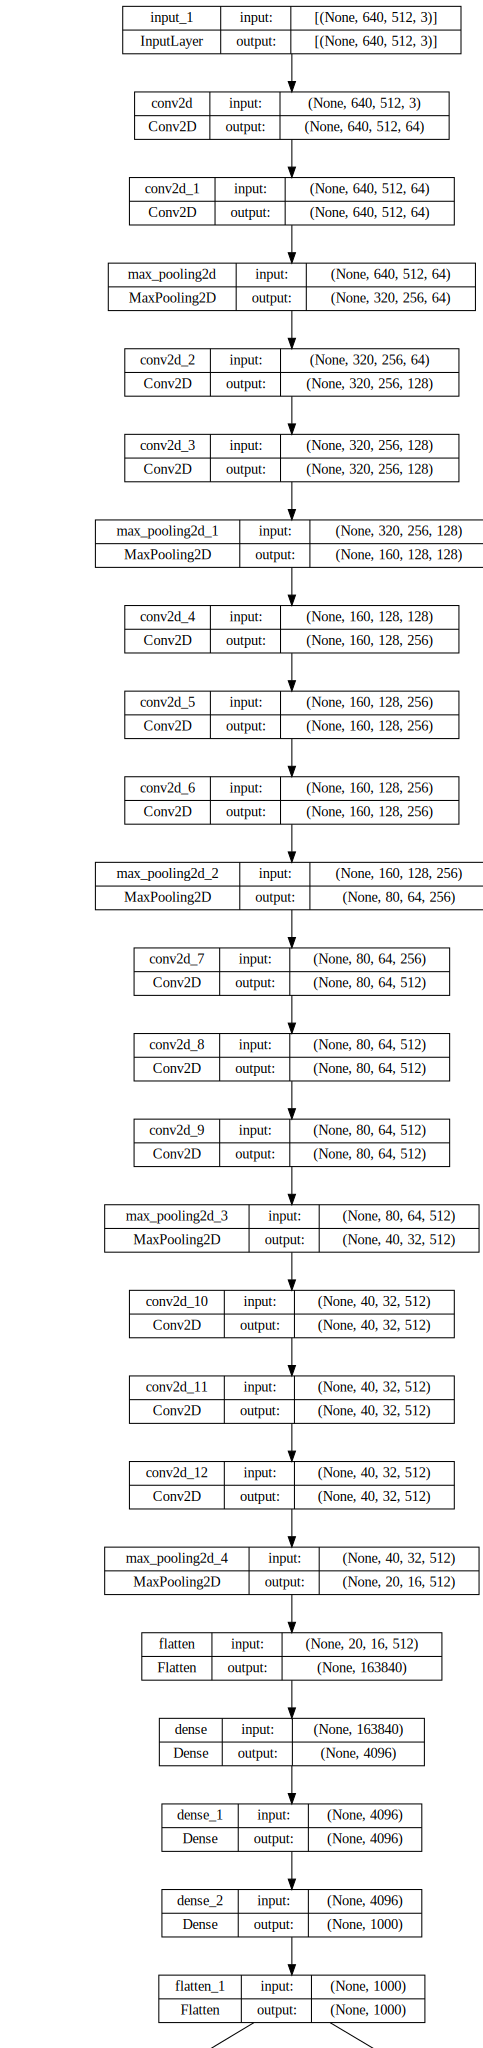

In [ ]:
# displaying the architecture of the bbox / label model in series with the VGG16 feature extractor

from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(bboxlabelmodel, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

**Model compilation and loss definition**

In [ ]:
# define a dictionary to set the loss methods 
from tensorflow.keras.optimizers import Adam
 
# categorical cross-entropy for the class label head and mean absolute error for the bounding box head - why?
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

# define a dictionary that specifies the weights per loss (both the class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

# initialize the optimizer, compile the model, and show the model summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 640, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 640, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                           

/home/sr42/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Model Training**

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}

# construct a second dictionary, this one for our target testing outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
# train the network for bounding box regression and class label prediction
print("[INFO] training model...")

H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

**Deploying the saved model**

In [ ]:
# importing the necessary libraries

from pyimagesearch import config
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
import numpy as np
import mimetypes
import argparse
import imutils
import pickle
import cv2
import os

In [ ]:
# assign directory of test images
directory = '../Test_data_images'
imagePaths = []

# iterate over files in that directory
for filename in os.listdir(directory):
	f = os.path.join(directory, filename)
	# checking if it is a file
	if os.path.isfile(f):
		imagePaths.append(f)

# load our object detector and label binarizer from disk
print("[INFO] loading object detector...")
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

respd = pd.Dataframe(columns = ['Test Image', 'Prediction String'])

# loop over the images that we'll be testing using our bounding box regression model
for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image) / 255.0
	image = np.expand_dims(image, axis=0)

	# predict the bounding box of the object along with the class label
	confidence = None # modify to account for results from model.predict()
	(boxPreds, labelPreds) = model.predict(image)
	(startX, startY, endX, endY) = boxPreds[0]

	# determine the class label with the largest predicted probability
	i = np.argmax(labelPreds, axis=1)
	label = lb.classes_[i][0]
		
	# load the input image (in OpenCV format), resize it such that it fits on our screen, and grab its dimensions
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]

	# scale the predicted bounding box coordinates based on the image dimensions
	startX = int(startX * w)
	startY = int(startY * h)
	endX = int(endX * w)
	endY = int(endY * h)

	# draw the predicted bounding box and class label on the image
	y = startY - 10 if startY - 10 > 10 else startY + 10
	cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
	cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

	# final result declaration
	print('------------------------------------------------------------------------------------')
		
	# show the output image
	cv2.imshow("Output", image)
	cv2.waitKey(0)
		
	print('Image path : ', imagePath)
	print('Label : ', label)
	print('Confidence : ', confidence)
	print('BBox diagonal coordinates : ', (startX, startY, endX, endY))
	
	print('------------------------------------------------------------------------------------')
		
	if label == 'Airplane':
		lbnumber = 0
	elif label == 'Bird':
		lbnumber == 1
	elif label == 'Drone':
		lbnumber == 2
	else:
		lbnumber == 3
		
	predictionString = '{' + lbnumber + ' ' + confidence + ' ' + startX + ' ' + startY + ' ' + endX + ' ' + endY + '}'
	newRow = {'Test Image' : imagePath, 'Prediction String' : predictionString}
	respd.append(newRow, ignore_index = True)
	
respd.to_csv('./results.csv')